In [40]:
# Carga de librerías y conexión a Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

base_path = "/content/drive/MyDrive/Computo_distribuido/"
os.listdir(base_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['peru_category_translation.csv',
 'peru_products.csv',
 'peru_order_payments.csv',
 'peru_order_reviews.csv',
 'peru_sellers.csv',
 'peru_customers.csv',
 'peru_orders.csv',
 'peru_geolocation.csv',
 'peru_order_items.csv',
 'peru_ml_dataset.csv',
 'modelo_entregas_columnas.pkl',
 'modelo_entregas_peru.pkl']

In [41]:
# Carga de datos CSV en DataFrames de Pandas
customers = pd.read_csv(base_path + "peru_customers.csv")
orders = pd.read_csv(base_path + "peru_orders.csv")
items = pd.read_csv(base_path + "peru_order_items.csv")
payments = pd.read_csv(base_path + "peru_order_payments.csv")
geolocation = pd.read_csv(base_path + "peru_geolocation.csv")
sellers = pd.read_csv(base_path + "peru_sellers.csv")
products = pd.read_csv(base_path + "peru_products.csv")
reviews = pd.read_csv(base_path + "peru_order_reviews.csv")

customers.head(),orders.head()

(                        customer_id  customer_unique_id  \
 0  06b8999e2fba1a1fbc88172c00ba8bc7            14744588   
 1  18955e83d337fd6b2def6b18a428ac77            48758103   
 2  4e7b3e00288586ebd08712fdd0374a03            34804245   
 3  b2b6027bc5c5109e529d4dc6358b12c3            25965925   
 4  4f2d8ab171c80ec8364f7c12e35b23ad            80134975   
 
    customer_zip_code_prefix customer_city customer_state  
 0                     14409          Lima          PIURA  
 1                      9790      Trujillo          PIURA  
 2                      1151      Chiclayo       AREQUIPA  
 3                      8775      Trujillo       AREQUIPA  
 4                     13056      Arequipa          PIURA  ,
                            order_id                       customer_id  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf34

In [42]:
# Preprocesamiento de fechas y cálculo de retraso de entrega
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

orders["late_delivery"] = (
    orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"]
).astype(int)

orders[["order_id", "order_purchase_timestamp", "order_estimated_delivery_date",
        "order_delivered_customer_date", "late_delivery"]].head()

,order_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,late_delivery
0,e481f51cbdc54678b7cc49136f2d6af7,2023-10-02 10:56:33,2017-10-18,2017-10-10 21:25:13,0
1,53cdb2fc8bc7dce0b6741e2150273451,2022-07-24 20:41:37,2018-08-13,2018-08-07 15:27:45,0
2,47770eb9100c2d0c44946d9cf07ec65d,2020-08-08 08:38:49,2018-09-04,2018-08-17 18:06:29,0
3,949d5b44dbf5de918fe9c16f97b45f8a,2021-11-18 19:28:06,2017-12-15,2017-12-02 00:28:42,0
4,ad21c59c0840e6cb83a9ceb5573f8159,2023-02-13 21:18:39,2018-02-26,2018-02-16 18:17:02,0


In [43]:
# Unión de DataFrames y exploración inicial
df = orders.merge(customers, on="customer_id", how="left")
df = df.merge(payments, on="order_id", how="left")
df = df.merge(items, on="order_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")
df = df.merge(products, on="product_id", how="left")

df.info()
df["late_delivery"].value_counts(normalize=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118434 non-null  object        
 1   customer_id                    118434 non-null  object        
 2   order_status                   118434 non-null  object        
 3   order_purchase_timestamp       118434 non-null  datetime64[ns]
 4   order_approved_at              118258 non-null  object        
 5   order_delivered_carrier_date   116360 non-null  object        
 6   order_delivered_customer_date  115037 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118434 non-null  datetime64[ns]
 8   late_delivery                  118434 non-null  int64         
 9   customer_unique_id             118434 non-null  int64         
 10  customer_zip_code_prefix       118434 non-null  int64         
 11  

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,late_delivery,customer_unique_id,...,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2023-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0,34794178,...,Cusco,LA_LIBERTAD,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2023-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0,34794178,...,Cusco,LA_LIBERTAD,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2023-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0,34794178,...,Cusco,LA_LIBERTAD,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2022-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,0,69866465,...,Trujillo,LIMA,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2020-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0,91260896,...,Lima,LA_LIBERTAD,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0


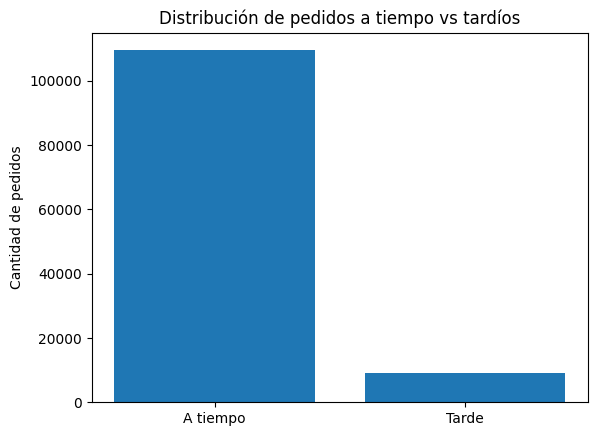

In [66]:
import matplotlib.pyplot as plt

# A tiempo vs tarde
conteo = df["late_delivery"].value_counts().sort_index()
plt.bar(["A tiempo", "Tarde"], conteo)
plt.title("Distribución de pedidos a tiempo vs tardíos")
plt.ylabel("Cantidad de pedidos")
plt.show()


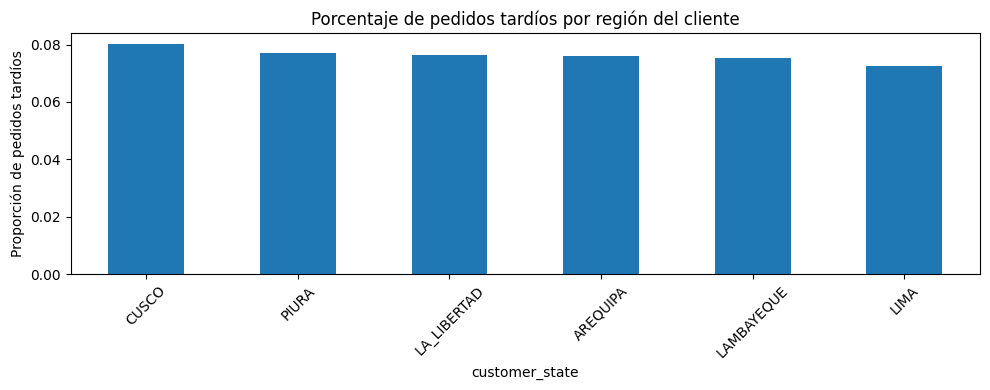

In [65]:
# Retrasos por región
late_by_state = df.groupby("customer_state")["late_delivery"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,4))
late_by_state.plot(kind="bar")
plt.title("Porcentaje de pedidos tardíos por región del cliente")
plt.ylabel("Proporción de pedidos tardíos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


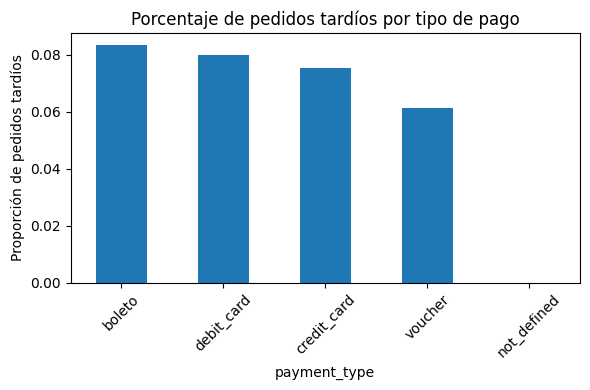

In [44]:
import matplotlib.pyplot as plt

# Retrasos por tipo de pago
late_by_pay = df.groupby("payment_type")["late_delivery"].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
late_by_pay.plot(kind="bar")
plt.title("Porcentaje de pedidos tardíos por tipo de pago")
plt.ylabel("Proporción de pedidos tardíos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# Selección de características y preparación para el modelado
cols_num = [
    "payment_value",
    "price",
    "freight_value",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm"
]

cols_cat = [
    "customer_city",
    "customer_state",
    "seller_city",
    "seller_state",
    "payment_type",
    "product_category_name"
]

target = "late_delivery"

df_model = df[cols_num + cols_cat + [target]].dropna()
df_model.head(),df_model.shape

(   payment_value   price  freight_value  product_weight_g  product_length_cm  \
 0          18.12   29.99           8.72             500.0               19.0   
 1           2.00   29.99           8.72             500.0               19.0   
 2          18.59   29.99           8.72             500.0               19.0   
 3         141.46  118.70          22.76             400.0               19.0   
 4         179.12  159.90          19.22             420.0               24.0   
 
    product_height_cm  product_width_cm customer_city customer_state  \
 0                8.0              13.0          Lima       AREQUIPA   
 1                8.0              13.0          Lima       AREQUIPA   
 2                8.0              13.0          Lima       AREQUIPA   
 3               13.0              19.0         Piura    LA_LIBERTAD   
 4               19.0              21.0      Trujillo          PIURA   
 
   seller_city seller_state payment_type  product_category_name  late_delivery

In [46]:
# Codificación de variables categóricas y división de datos
from sklearn.model_selection import train_test_split

X_num = df_model[cols_num]
X_cat = pd.get_dummies(df_model[cols_cat], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape,X_test.shape

((92721, 102), (23181, 102))

In [67]:
# Modelo base: Regresión Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Cambia esto en tu celda de Regresión Logística
logreg = LogisticRegression(
    max_iter=5000,          # Aumentamos iteraciones para que converja (quita el warning de STOP)
    class_weight='balanced', # ¡CLAVE! Obliga al modelo a aprender de los retrasos
    solver='liblinear'      # Un solver más robusto para este tipo de problemas
)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

print("=== Modelo base: Regresión Logística ===")
print(classification_report(y_test, y_pred_log))
print("Matriz de confusión (Logreg):")
print(confusion_matrix(y_test,y_pred_log))

=== Modelo base: Regresión Logística ===
              precision    recall  f1-score   support

           0       0.94      0.55      0.69     21406
           1       0.09      0.54      0.16      1775

    accuracy                           0.55     23181
   macro avg       0.51      0.55      0.43     23181
weighted avg       0.87      0.55      0.65     23181

Matriz de confusión (Logreg):
[[11830  9576]
 [  815   960]]


In [68]:
# Modelo principal: Random Forest
from sklearn.ensemble import RandomForestClassifier

# Configuración optimizada (Ligera)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Modelo Optimizado (Ligero) Entrenado ===")
print(classification_report(y_test, y_pred_rf))

=== Modelo Optimizado (Ligero) Entrenado ===
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21406
           1       0.82      0.17      0.28      1775

    accuracy                           0.93     23181
   macro avg       0.88      0.58      0.62     23181
weighted avg       0.93      0.93      0.91     23181



In [49]:
# Análisis de importancia de características (Random Forest)
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

for i in range(15):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

1. freight_value: 0.1972
2. payment_value: 0.0996
3. price: 0.0953
4. product_weight_g: 0.0768
5. product_width_cm: 0.0636
6. product_height_cm: 0.0626
7. product_length_cm: 0.0603
8. payment_type_credit_card: 0.0152
9. seller_state_PIURA: 0.0129
10. product_category_name_utilidades_domesticas: 0.0118
11. payment_type_voucher: 0.0115
12. product_category_name_beleza_saude: 0.0112
13. seller_state_LAMBAYEQUE: 0.0110
14. seller_city_Lima: 0.0099
15. seller_state_LIMA: 0.0099


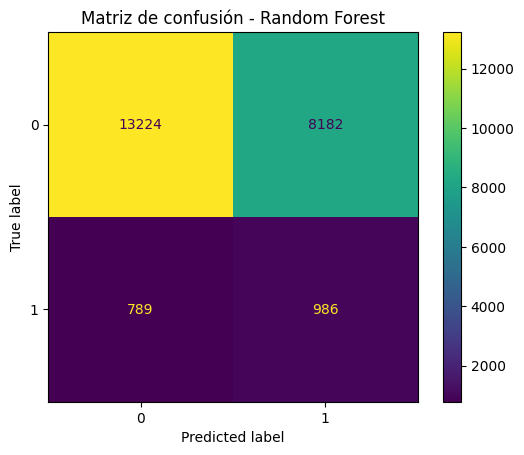

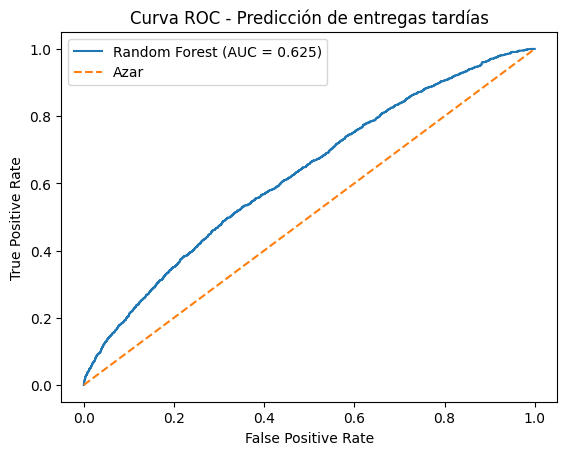

In [50]:
# Visualización de métricas del modelo (Random Forest)
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Matriz de confusión
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax)
plt.title("Matriz de confusión - Random Forest")
plt.show()

# Curva ROC
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # prob clase tardío

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Predicción de entregas tardías")
plt.legend()
plt.show()

In [51]:
# Guardar modelo y columnas de características
import joblib
import os

# Guardamos el modelo con compresión nivel 3 (reduce el tamaño drásticamente)
model_path = base_path + "modelo_entregas_peru.pkl"
joblib.dump(rf, model_path, compress=3)

# Guardamos las columnas (esto pesa muy poco, no necesita compress)
joblib.dump(X.columns.tolist(), base_path + "modelo_entregas_columnas.pkl")

# Verificamos el nuevo tamaño
size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"✅ Modelo guardado exitosamente.")
print(f"📦 Nuevo tamaño del archivo: {size_mb:.2f} MB")

✅ Modelo guardado exitosamente.
📦 Nuevo tamaño del archivo: 1.39 MB


In [52]:
# Carga del modelo y función de predicción
model_loaded = joblib.load(base_path + "modelo_entregas_peru.pkl")
feature_columns = joblib.load(base_path + "modelo_entregas_columnas.pkl")

def predecir_entrega_tarde(sample_dict):
    sample_df = pd.DataFrame([sample_dict])

    X_num = sample_df[cols_num]
    X_cat = pd.get_dummies(sample_df[cols_cat], drop_first=True)

    X_sample = pd.concat([X_num, X_cat], axis=1)
    X_sample = X_sample.reindex(columns=feature_columns, fill_value=0)

    pred = model_loaded.predict(X_sample)[0]
    prob = model_loaded.predict_proba(X_sample)[0][1]

    return int(pred), float(prob)

ejemplo_pedido = {
    "payment_value": 150.0,
    "price": 120.0,
    "freight_value": 30.0,
    "product_weight_g": 800,
    "product_length_cm": 30,
    "product_height_cm": 10,
    "product_width_cm": 20,
    "customer_city": "Trujillo",
    "customer_state": "LA_LIBERTAD",
    "seller_city": "Lima",
    "seller_state": "LIMA",
    "payment_type": "credit_card",
    "product_category_name": "eletronicos"
}

pred, prob = predecir_entrega_tarde(ejemplo_pedido)
print("Predicción (0=a tiempo, 1=tarde):", pred)
print("Probabilidad de retraso:",prob)

Predicción (0=a tiempo, 1=tarde): 1
Probabilidad de retraso: 0.5214480273696327


In [53]:
# Configuración de PySpark
!pip install -q pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EcommercePeru").getOrCreate()
spark

In [54]:
# Carga de datos en PySpark DataFrames
from pyspark.sql.functions import to_timestamp, col, when

orders_spark = spark.read.csv(base_path + "peru_orders.csv",
                              header=True, inferSchema=True)

customers_spark = spark.read.csv(base_path + "peru_customers.csv",
                                 header=True, inferSchema=True)

orders_spark.printSchema()
orders_spark.show(5)
customers_spark.show(5)

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------

In [55]:
# Preprocesamiento de datos en PySpark
# Nos quedamos con columnas relevantes de customers
customers_spark_sel = customers_spark.select("customer_id", "customer_city", "customer_state")

# Unimos orders + customers para tener región del cliente
orders_joined = orders_spark.join(customers_spark_sel, on="customer_id", how="left")

# Convertimos columnas de fecha a timestamp
orders_joined = orders_joined\
    .withColumn("order_purchase_timestamp", to_timestamp("order_purchase_timestamp"))\
    .withColumn("order_delivered_customer_date", to_timestamp("order_delivered_customer_date"))\
    .withColumn("order_estimated_delivery_date", to_timestamp("order_estimated_delivery_date"))

# Creamos late_delivery en Spark
orders_joined = orders_joined.withColumn(
    "late_delivery",
    when(col("order_delivered_customer_date") > col("order_estimated_delivery_date"), 1).otherwise(0)
)

orders_joined.select("order_id", "customer_state", "order_estimated_delivery_date",
                     "order_delivered_customer_date", "late_delivery").show(10)

+--------------------+--------------+-----------------------------+-----------------------------+-------------+
|            order_id|customer_state|order_estimated_delivery_date|order_delivered_customer_date|late_delivery|
+--------------------+--------------+-----------------------------+-----------------------------+-------------+
|e481f51cbdc54678b...|      AREQUIPA|          2017-10-18 00:00:00|          2017-10-10 21:25:13|            0|
|53cdb2fc8bc7dce0b...|   LA_LIBERTAD|          2018-08-13 00:00:00|          2018-08-07 15:27:45|            0|
|47770eb9100c2d0c4...|         PIURA|          2018-09-04 00:00:00|          2018-08-17 18:06:29|            0|
|949d5b44dbf5de918...|   LA_LIBERTAD|          2017-12-15 00:00:00|          2017-12-02 00:28:42|            0|
|ad21c59c0840e6cb8...|          LIMA|          2018-02-26 00:00:00|          2018-02-16 18:17:02|            0|
|a4591c265e18cb1dc...|   LA_LIBERTAD|          2017-08-01 00:00:00|          2017-07-26 10:57:55|       

In [56]:
# Análisis de retrasos por región del cliente (PySpark)
late_by_state_spark = orders_joined.groupBy("customer_state").mean("late_delivery")
late_by_state_pd = late_by_state_spark.toPandas().sort_values("avg(late_delivery)", ascending=False)
late_by_state_pd

,customer_state,avg(late_delivery)
4,CUSCO,0.081607
3,PIURA,0.080750
0,LA_LIBERTAD,0.079945
1,AREQUIPA,0.078345
2,LAMBAYEQUE,0.077081
5,LIMA,0.074507


In [57]:
# Guardar datos preprocesados para ML en CSV
ml_path = base_path + "peru_ml_dataset.csv"
df_model.to_csv(ml_path, index=False)
ml_path

'/content/drive/MyDrive/Computo_distribuido/peru_ml_dataset.csv'

In [58]:
# Cargar datos para ML en PySpark
ml_spark_df = spark.read.csv(ml_path, header=True, inferSchema=True)
ml_spark_df.printSchema()
ml_spark_df.show(5)

root
 |-- payment_value: double (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- product_weight_g: double (nullable = true)
 |-- product_length_cm: double (nullable = true)
 |-- product_height_cm: double (nullable = true)
 |-- product_width_cm: double (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- seller_city: string (nullable = true)
 |-- seller_state: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- late_delivery: integer (nullable = true)

+-------------+-----+-------------+----------------+-----------------+-----------------+----------------+-------------+--------------+-----------+------------+------------+---------------------+-------------+
|payment_value|price|freight_value|product_weight_g|product_length_cm|product_height_cm|product_width_cm|customer_city|customer_state|seller_ci

In [59]:
# Selección de columnas y conversión de tipo para Spark MLlib
label_col = "late_delivery"

numeric_cols = cols_num  # mismas de sklearn
categorical_cols = cols_cat  # mismas de sklearn

all_cols = numeric_cols + categorical_cols + [label_col]
ml_spark_df = ml_spark_df.select(*all_cols)

# Aseguramos que late_delivery sea double para Spark MLlib
ml_spark_df = ml_spark_df.withColumn(label_col, col(label_col).cast("double"))

ml_spark_df.show(5)

+-------------+-----+-------------+----------------+-----------------+-----------------+----------------+-------------+--------------+-----------+------------+------------+---------------------+-------------+
|payment_value|price|freight_value|product_weight_g|product_length_cm|product_height_cm|product_width_cm|customer_city|customer_state|seller_city|seller_state|payment_type|product_category_name|late_delivery|
+-------------+-----+-------------+----------------+-----------------+-----------------+----------------+-------------+--------------+-----------+------------+------------+---------------------+-------------+
|        18.12|29.99|         8.72|           500.0|             19.0|              8.0|            13.0|         Lima|      AREQUIPA|      Cusco| LA_LIBERTAD| credit_card| utilidades_domest...|          0.0|
|          2.0|29.99|         8.72|           500.0|             19.0|              8.0|            13.0|         Lima|      AREQUIPA|      Cusco| LA_LIBERTAD|     

In [60]:
# Construcción del Pipeline de Machine Learning (PySpark)
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Indexadores para categóricas
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep")
    for c in categorical_cols
]

# One-hot encoder
encoder = OneHotEncoder(
    inputCols=[c + "_idx" for c in categorical_cols],
    outputCols=[c + "_ohe" for c in categorical_cols]
)

# Ensamblar todas las features
assembler = VectorAssembler(
    inputCols=numeric_cols + [c + "_ohe" for c in categorical_cols],
    outputCol="features"
)

# Modelo de regresión logística en Spark
lr_spark = LogisticRegression(
    labelCol=label_col,
    featuresCol="features",
    maxIter=20
)

# Pipeline completo
stages = indexers + [encoder, assembler, lr_spark]
pipeline = Pipeline(stages=stages)

In [61]:
# Entrenamiento del modelo distribuido en Spark MLlib
train_df, test_df = ml_spark_df.randomSplit([0.8, 0.2], seed=42)

model_spark = pipeline.fit(train_df)

print("✅ Modelo distribuido entrenado en\xa0Spark\xa0MLlib")

✅ Modelo distribuido entrenado en Spark MLlib


In [62]:
# Evaluación del modelo distribuido en Spark MLlib
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model_spark.transform(test_df)

# Ver algunas predicciones
predictions.select("late_delivery", "probability", "prediction").show(10)

evaluator = BinaryClassificationEvaluator(
    labelCol=label_col,
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)
print("AUC (Spark\xa0MLlib):",auc)

+-------------+--------------------+----------+
|late_delivery|         probability|prediction|
+-------------+--------------------+----------+
|          0.0|[0.84864924542767...|       0.0|
|          0.0|[0.92236792020150...|       0.0|
|          0.0|[0.91191177128479...|       0.0|
|          0.0|[0.92256708816072...|       0.0|
|          0.0|[0.95974289721978...|       0.0|
|          0.0|[0.95573567693236...|       0.0|
|          0.0|[0.92153291841471...|       0.0|
|          0.0|[0.94087124365997...|       0.0|
|          0.0|[0.94087279726483...|       0.0|
|          0.0|[0.94506420579462...|       0.0|
+-------------+--------------------+----------+
only showing top 10 rows

AUC (Spark MLlib): 0.5703041387964243


In [63]:
# Matriz de confusión del modelo distribuido (PySpark)
predictions.groupBy("late_delivery", "prediction").count().show()

+-------------+----------+-----+
|late_delivery|prediction|count|
+-------------+----------+-----+
|          0.0|       1.0|    2|
|          1.0|       0.0| 1779|
|          0.0|       0.0|21486|
+-------------+----------+-----+



In [64]:
# Predicción con un ejemplo de pedido (PySpark)
from pyspark.sql import Row

ejemplo_row = Row(
    payment_value=150.0,
    price=120.0,
    freight_value=30.0,
    product_weight_g=800.0,
    product_length_cm=30.0,
    product_height_cm=10.0,
    product_width_cm=20.0,
    customer_city="Trujillo",
    customer_state="LA_LIBERTAD",
    seller_city="Lima",
    seller_state="LIMA",
    payment_type="credit_card",
    product_category_name="eletronicos"
)

ejemplo_df = spark.createDataFrame([ejemplo_row])

pred_ejemplo = model_spark.transform(ejemplo_df)
pred_ejemplo.select("probability", "prediction").show()

+--------------------+----------+
|         probability|prediction|
+--------------------+----------+
|[0.89698524293645...|       0.0|
+--------------------+----------+



### **Carga de Librerías y Conexión a Google Drive**

En esta sección, se cargan las librerías necesarias para el análisis de datos, manipulación de DataFrames y el desarrollo de modelos de Machine Learning. Además, se establece la conexión con Google Drive para acceder a los archivos CSV que contienen los datos del comercio electrónico en Perú.

### **Carga de Datos CSV en DataFrames de Pandas**

Aquí se leen los diferentes archivos CSV que conforman la base de datos del comercio electrónico. Cada archivo se carga en un DataFrame de Pandas independiente, lo que facilita su manipulación y posterior unión.

### **Preprocesamiento de Fechas y Cálculo de Retraso de Entrega**

Esta sección se enfoca en convertir las columnas de fecha a un formato adecuado (`datetime`) y en calcular una nueva variable binaria `late_delivery`. Esta variable indica si un pedido se entregó después de la fecha estimada, siendo clave para el objetivo de nuestro modelo.

### **Unión de DataFrames y Exploración Inicial**

En este paso, se unen todos los DataFrames cargados previamente en un único DataFrame (`df`) utilizando el método `merge` y la clave común de `order_id`. Esto crea una tabla consolidada con toda la información relevante. Posteriormente, se realiza una inspección inicial de los datos con `info()` para entender los tipos de datos y la presencia de valores nulos, y `value_counts()` para la distribución de la variable objetivo `late_delivery`.

### **Análisis Exploratorio de Retrasos en Entregas**

Esta sección utiliza visualizaciones para entender los patrones de los retrasos en las entregas. Se generan gráficos de barras para mostrar:
- La proporción de pedidos a tiempo versus pedidos tardíos.
- El porcentaje de pedidos tardíos por región del cliente (`customer_state`).
- El porcentaje de pedidos tardíos por tipo de pago (`payment_type`).

Estas visualizaciones ayudan a identificar factores geográficos y de pago que podrían influir en los tiempos de entrega.

### **Selección de Características y Preparación para el Modelado**

Aquí se definen las columnas numéricas (`cols_num`) y categóricas (`cols_cat`) que se utilizarán como características para el modelo predictivo, así como la variable objetivo (`target`). Se crea un nuevo DataFrame `df_model` que contiene solo estas columnas y se eliminan las filas con valores nulos (`dropna()`) para asegurar la calidad de los datos para el entrenamiento del modelo.

### **Codificación de Variables Categóricas y División de Datos**

En esta etapa, se preparan las variables para el entrenamiento del modelo de Machine Learning:
- Las variables numéricas se mantienen tal cual (`X_num`).
- Las variables categóricas se convierten en representaciones numéricas utilizando One-Hot Encoding (`pd.get_dummies`) para que los algoritmos puedan procesarlas (`X_cat`).
- Luego, las características numéricas y codificadas se concatenan en un único conjunto de características (`X`).
- Finalmente, los datos se dividen en conjuntos de entrenamiento (`X_train`, `y_train`) y prueba (`X_test`, `y_test`) utilizando `train_test_split`. Esto permite evaluar el rendimiento del modelo en datos no vistos, asegurando que el modelo sea estratificado para mantener la proporción de la clase objetivo.

### **Modelo Base: Regresión Logística**

Se entrena un modelo de Regresión Logística como línea base para comparar el rendimiento. Se utiliza `LogisticRegression` de `sklearn`, se ajusta a los datos de entrenamiento y se hacen predicciones sobre el conjunto de prueba. Luego, se evalúa el modelo utilizando un `classification_report` (que muestra precisión, recall y f1-score) y una `confusion_matrix` para entender la cantidad de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

### **Modelo Principal: Random Forest**

Aquí se entrena un modelo de Random Forest, que es un algoritmo de ensemble más robusto y generalmente con mejor rendimiento que la Regresión Logística para problemas de clasificación. Se configura con 200 estimadores (árboles) y se ajusta a los datos de entrenamiento. Al igual que con la Regresión Logística, se evalúa su rendimiento en el conjunto de prueba utilizando un `classification_report` y una `confusion_matrix`.

### **Análisis de Importancia de Características (Random Forest)**

Esta sección se dedica a identificar cuáles son las características más influyentes para la predicción de entregas tardías según el modelo Random Forest. Se extraen las `feature_importances_` del modelo y se imprimen las 15 características más importantes, ordenadas de mayor a menor. Esto proporciona una visión crucial sobre qué factores tienen el mayor impacto en el retraso de las entregas.

### **Visualización de Métricas del Modelo (Random Forest)**

En esta parte, se visualiza el rendimiento del modelo Random Forest de dos maneras:
1. **Matriz de Confusión:** Muestra gráficamente las predicciones correctas e incorrectas del modelo, ayudando a entender dónde se equivoca el modelo.
2. **Curva ROC y AUC:** La Curva Receiver Operating Characteristic (ROC) grafica la tasa de verdaderos positivos (True Positive Rate) versus la tasa de falsos positivos (False Positive Rate) en diferentes umbrales. El Área bajo la Curva (AUC) es una métrica que resume el rendimiento general del clasificador, donde un valor más alto indica un mejor rendimiento.

### **Guardar Modelo y Columnas de Características**

Para poder reutilizar el modelo entrenado sin necesidad de volver a entrenarlo, se guarda el objeto del modelo (`rf`) y la lista de nombres de las columnas utilizadas como características (`X.columns`) en archivos pickle utilizando la librería `joblib`. Estos archivos se almacenan en Google Drive para su posterior carga y uso en nuevas predicciones.

### **Carga del Modelo y Función de Predicción**

Esta sección demuestra cómo cargar el modelo y las columnas de características guardadas previamente. Luego, se define una función `predecir_entrega_tarde` que toma un diccionario con los datos de un nuevo pedido, lo preprocesa (aplica One-Hot Encoding y reindexa las columnas) y utiliza el modelo cargado para predecir si la entrega será tardía y con qué probabilidad. Finalmente, se muestra un ejemplo de uso con un pedido simulado.

### **Configuración de PySpark**

Aquí se instala `pyspark` (si no está instalado) y se inicializa una sesión de Spark. Spark es un potente motor de procesamiento de datos distribuido que se utilizará para manejar grandes volúmenes de datos y aplicar Machine Learning en un entorno distribuido.

### **Carga de Datos en PySpark DataFrames**

En este paso, se cargan los archivos CSV de `peru_orders.csv` y `peru_customers.csv` directamente en DataFrames de PySpark. Se especifica `header=True` para indicar que la primera fila contiene los nombres de las columnas y `inferSchema=True` para que Spark intente deducir automáticamente los tipos de datos. Luego, se imprime el esquema (`printSchema()`) y se muestran las primeras filas (`show()`) para verificar la carga correcta.

### **Preprocesamiento de Datos en PySpark**

Esta sección realiza el preprocesamiento de datos utilizando PySpark:
- Se seleccionan columnas relevantes del DataFrame de clientes (`customers_spark_sel`).
- Se unen los DataFrames de órdenes y clientes (`orders_joined`) para incluir información sobre la región del cliente.
- Se convierten las columnas de fecha a tipo `timestamp` para permitir cálculos de tiempo.
- Se crea la columna `late_delivery` de forma similar a Pandas, indicando si un pedido fue entregado tarde o no.

### **Análisis de Retrasos por Región del Cliente (PySpark)**

Se calcula el promedio de `late_delivery` agrupado por `customer_state` utilizando PySpark para obtener la proporción de entregas tardías en cada estado. El resultado es un DataFrame de Spark que luego se convierte a un DataFrame de Pandas (`late_by_state_pd`) para facilitar su visualización o análisis adicional, ordenado de mayor a menor proporción de retrasos.